## QAOA Parameter Transfer: Graph A (Baseline)

### 1. Setup
- Imports
- Graph drawing function
- Helper utils

### 2. Graph A: MaxCut Formulation
- Create graph
- Show adjacency + plot

### 3. Convert to QUBO + Ising
- Use Qiskit Optimization

### 4. QAOA Ansatz
- Create and show circuit (with measurement)
- Create circuit (no measurement) for Estimator

### 5. QAOA Optimization
- Define cost function
- Run COBYLA
- Save trajectory

### 6. Results
- Print final energy + parameters
- Plot cost vs iteration
- Save outputs (JSON/PNG)



### Setup

In [2]:
%pip install qiskit==1.1.0 qiskit_optimization==0.6.1 matplotlib networkx pylatexenc --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path

from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Estimator
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize

%matplotlib inline

### Graph A - Build and Visualize

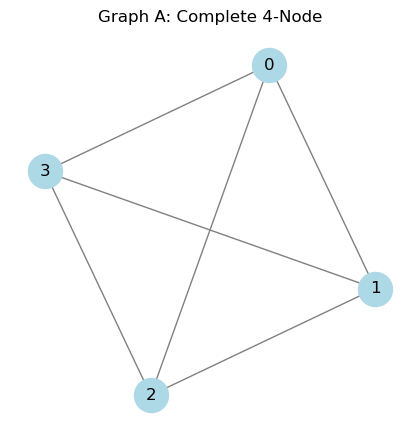

In [2]:
# Graph A: Complete 4-node
G = nx.complete_graph(4)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, edge_color='gray')
plt.title("Graph A: Complete 4-Node")
plt.show()


### Convert to QUBO

In [3]:
# Get adjacency matrix
w = nx.adjacency_matrix(G).todense()
maxcut = Maxcut(w)
qp = maxcut.to_quadratic_program()

# Convert to Ising Hamiltonian
qubit_op, offset = qp.to_ising()
print("Pauli-form Hamiltonian:\n", qubit_op)


Pauli-form Hamiltonian:
 SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### QAOA

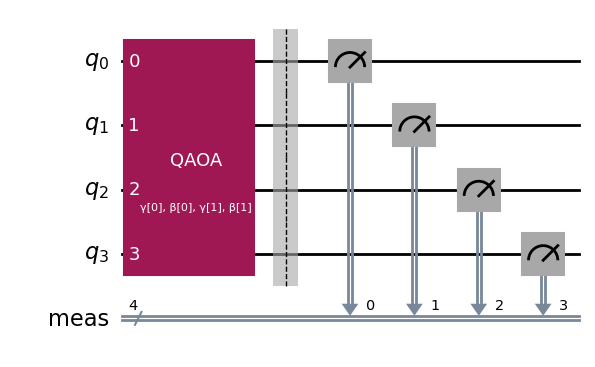

In [4]:
reps = 2
circuit = QAOAAnsatz(cost_operator=qubit_op, reps=reps)

# For display
circuit_with_measure = circuit.copy()
circuit_with_measure.measure_all()

# Draw
circuit_with_measure.draw('mpl')

### Define Estimator and Cost Function

In [5]:
estimator = Estimator()
objective_func_vals = []

def cost_func_estimator(params):
    job = estimator.run([circuit], [qubit_op], [params])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost


### Optimization

In [6]:
# Initial guess for 2-rep QAOA: [γ1, β1, γ2, β2]
init_params = [np.pi, np.pi/2] * reps

result = minimize(
    cost_func_estimator,
    x0=init_params,
    method='COBYLA',
    tol=1e-2
)

print("Final cost:", result.fun)
print("Optimal parameters:", result.x)


Final cost: -0.9876202417905122
Optimal parameters: [3.98685856 2.08272959 2.34588922 2.40023421]


### Vizualize and Save

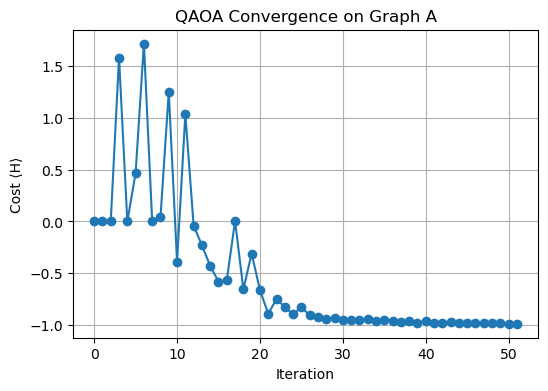

In [27]:
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(objective_func_vals, marker='o')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost ⟨H⟩")
ax.set_title("QAOA Convergence on Graph A")
ax.grid(True)
plt.show()


In [28]:
Path("results").mkdir(exist_ok=True)

with open("results/graph_a_params.json", "w") as f:
    json.dump({
        "optimal_params": result.x.tolist(),
        "final_cost": result.fun,
        "cost_trajectory": objective_func_vals
    }, f)

fig.savefig("results/graph_a_convergence.png", dpi=300)


## QAOA Parameter Transfer: Graph B (Perturbed from A)


### 7. Setup for Graph B
- Load saved results from Graph A
- Define helper function to run QAOA on a new graph
- Initialize Estimator for reuse

### 8. Graph B: MaxCut Formulation
- Create Graph B by removing one edge from Graph A
- Plot the perturbed graph for visual comparison

### 9. Convert to QUBO + Ising
- Use Qiskit Optimization to convert Graph B to a Quadratic Program
- Translate to Pauli-form Hamiltonian

### 10. QAOA Ansatz for Graph B
- Build QAOA circuit with the same number of repetitions (reps)
- Create a copy with `measure_all()` for visualization

### 11. QAOA Optimization on Graph B

#### 11A. Random Initialization
- Define cost function that logs cost at each iteration
- Run COBYLA starting from a random initial parameter vector
- Record final cost and cost trajectory

#### 11B. Transferred Initialization (from Graph A)
- Load optimal parameters from


### Graph B - Slightly perturbed Graph A

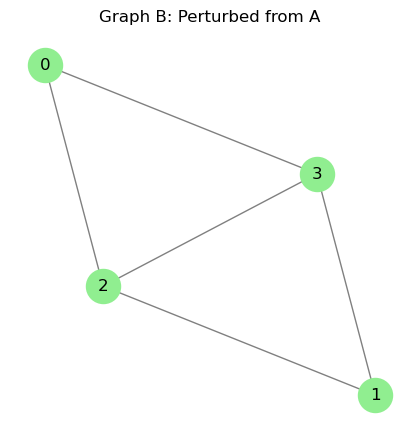

In [9]:
# Graph B: Remove one edge from Graph A
G_b = nx.complete_graph(4)
G_b.remove_edge(0, 1)  # slight perturbation
pos_b = nx.spring_layout(G_b, seed=42)

plt.figure(figsize=(4, 4))
nx.draw(G_b, pos_b, with_labels=True, node_color='lightgreen', node_size=600, edge_color='gray')
plt.title("Graph B: Perturbed from A")
plt.show()

### QUBO and Hamiltonian 

In [10]:
w_b = nx.adjacency_matrix(G_b).todense()
maxcut_b = Maxcut(w_b)
qp_b = maxcut_b.to_quadratic_program()

qubit_op_b, offset_b = qp_b.to_ising()

In [11]:
circuit_b = QAOAAnsatz(cost_operator=qubit_op_b, reps=reps)

In [13]:
objective_func_vals_rand = []
objective_func_vals_transfer = []

def cost_func_estimator_b(params, tracker):
    job = estimator.run([circuit_b], [qubit_op_b], [params])
    result = job.result()
    cost = result.values[0]
    tracker.append(cost)
    return cost

### QAOA - Random Init

In [14]:
init_params_rand = [np.pi, np.pi/2] * reps

result_rand = minimize(
    lambda p: cost_func_estimator_b(p, objective_func_vals_rand),
    x0=init_params_rand,
    method='COBYLA',
    tol=1e-2
)

### QAOA - parameter transfer

In [15]:
with open("results/graph_a_params.json", "r") as f:
    graph_a_data = json.load(f)

init_params_transfer = graph_a_data["optimal_params"]

result_transfer = minimize(
    lambda p: cost_func_estimator_b(p, objective_func_vals_transfer),
    x0=init_params_transfer,
    method='COBYLA',
    tol=1e-2
)

### Compare convergence

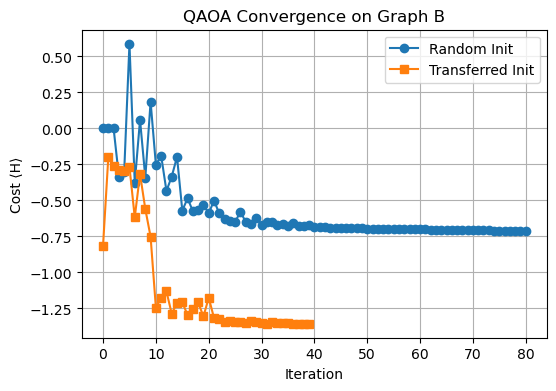

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(objective_func_vals_rand, label="Random Init", marker='o')
ax.plot(objective_func_vals_transfer, label="Transferred Init", marker='s')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost ⟨H⟩")
ax.set_title("QAOA Convergence on Graph B")
ax.legend()
ax.grid(True)
plt.show()

fig.savefig("results/graph_b_convergence_comparison.png")

Interpretation from the Plot
- Random Init: Converges slowly and flattens at a higher cost (−0.75)

- Transferred Init: Drops quickly and reaches a significantly lower cost (−1.35)

*Conclusion*: Transferred parameters helped QAOA converge faster and to a better solution



### Log results

In [17]:
with open("results/graph_b_results.json", "w") as f:
    json.dump({
        "random_final_cost": result_rand.fun,
        "random_optimal_params": result_rand.x.tolist(),
        "random_cost_trajectory": objective_func_vals_rand,
        "transfer_final_cost": result_transfer.fun,
        "transfer_optimal_params": result_transfer.x.tolist(),
        "transfer_cost_trajectory": objective_func_vals_transfer
    }, f)


## QAOA Parameter Transfer: Graph C (5 Nodes)

### 13. Graph C: MaxCut Formulation
- Create Graph C with 5 nodes (e.g., random or cycle)
- Visualize structure and adjacency

### 14. Convert to QUBO + Ising
- Use Qiskit Optimization to translate to cost Hamiltonian

### 15. QAOA Ansatz for Graph C
- Build QAOA circuit with same number of reps
- Prepare Estimator-compatible version

### 16. QAOA Optimization

#### 16A. Random Initialization
- Run COBYLA with default init
- Record cost trajectory

#### 16B. Transferred Initialization (from Graph A)
- Load parameters from Graph A
- Run COBYLA starting from these
- Record cost trajectory

### 17. Results and Comparison
- Plot cost vs iteration (random vs transfer)
- Save figure and results
- Reflect: How well did parameters generalize?


### Graph C - 5 node random graph

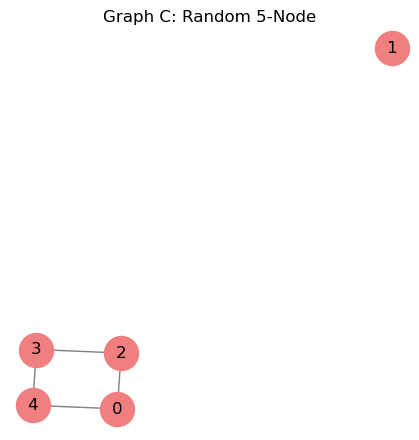

In [30]:
G_c = nx.erdos_renyi_graph(n=5, p=0.5, seed=10)
pos_c = nx.spring_layout(G_c, seed=10)

plt.figure(figsize=(4, 4))
nx.draw(G_c, pos_c, with_labels=True, node_color='lightcoral', node_size=600, edge_color='gray')
plt.title("Graph C: Random 5-Node")
plt.show()

### Convert to QUBO + Ising

In [31]:
w_c = nx.adjacency_matrix(G_c).todense()
maxcut_c = Maxcut(w_c)
qp_c = maxcut_c.to_quadratic_program()
qubit_op_c, offset_c = qp_c.to_ising()

### QAOA Circuit for Graph C

In [32]:
circuit_c = QAOAAnsatz(cost_operator=qubit_op_c, reps=reps)

### Cost Function estimator

In [33]:
objective_func_vals_c_rand = []
objective_func_vals_c_transfer = []

def cost_func_estimator_c(params, tracker):
    job = estimator.run([circuit_c], [qubit_op_c], [params])
    result = job.result()
    cost = result.values[0]
    tracker.append(cost)
    return cost

### Random Init

In [34]:
init_params_c_rand = [np.pi, np.pi/2] * reps

result_c_rand = minimize(
    lambda p: cost_func_estimator_c(p, objective_func_vals_c_rand),
    x0=init_params_c_rand,
    method='COBYLA',
    tol=1e-2
)

### Transferred Init

In [35]:
with open("results/graph_a_params.json", "r") as f:
    graph_a_params = json.load(f)["optimal_params"]

result_c_transfer = minimize(
    lambda p: cost_func_estimator_c(p, objective_func_vals_c_transfer),
    x0=graph_a_params,
    method='COBYLA',
    tol=1e-2
)

### Plot and Save

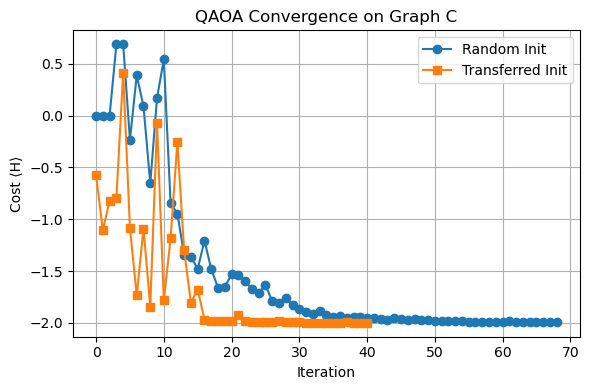

In [36]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(objective_func_vals_c_rand, label="Random Init", marker='o')
ax.plot(objective_func_vals_c_transfer, label="Transferred Init", marker='s')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost ⟨H⟩")
ax.set_title("QAOA Convergence on Graph C")
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig("results/graph_c_convergence_comparison.png", dpi=300)
plt.show()

# Save raw data
with open("results/graph_c_results.json", "w") as f:
    json.dump({
        "random_final_cost": result_c_rand.fun,
        "transfer_final_cost": result_c_transfer.fun,
        "random_cost_trajectory": objective_func_vals_c_rand,
        "transfer_cost_trajectory": objective_func_vals_c_transfer,
        "random_optimal_params": result_c_rand.x.tolist(),
        "transfer_optimal_params": result_c_transfer.x.tolist()
    }, f)


Interpretation from the Plot
- Random Init: Converges slowly and flattens at -2.0

- Transferred Init: Drops quickly but also reaches -2.0

*Conclusion*: Transferred parameters helped QAOA converge faster.

## Prototype: Parameter Transfer Strategy Selection (RL-Inspired)

### 18. Motivation and Setup
- Discuss the idea: simulate an agent choosing between multiple warm-start strategies
- Define goal: compare early performance across strategies (after limited QAOA iterations)
- Load Graph C again
- Re-import Graph A’s parameters

### 19. Define Transfer Strategies
- Strategy 1: Random Init (`[π, π/2] * reps`)
- Strategy 2: Direct Transfer (Graph A parameters)
- Strategy 3: Noisy Transfer (Graph A + Gaussian noise)

### 20. Evaluate Strategies with Fixed Iteration Budget
- For each strategy:
  - Run `COBYLA` with a small `maxiter`
  - Record the cost at each iteration
  - Store final cost and parameter output

### 21. Plot Cost Trajectories
- Plot cost vs iteration for all 3 strategies
- Save plot to file

### 22. Analyze and Compare
- Print final costs
- Optionally rank strategies by early performance
- Summarize: Which one converged fastest? Which gave best early cost?

### 23. Interpretation
- Discuss: how this mimics RL/bandit behavior
- Justify: how this could evolve into a learned policy that selects or adapts initializations
- Optional: suggest how graph features could be used as input in future learning setup

### 24. Save Outputs
- Save results as JSON
- Save convergence plot (e.g., `graph_c_rl_bandit_eval.png`)

### Define all strategies

In [37]:
from scipy.optimize import minimize

# Load Graph A optimal parameters
with open("results/graph_a_params.json", "r") as f:
    graph_a_params = json.load(f)["optimal_params"]

strategies = {
    "random_init": [np.pi, np.pi/2] * reps,
    "direct_transfer": graph_a_params,
    "noisy_transfer": (np.array(graph_a_params) + np.random.normal(0, 0.1, len(graph_a_params))).tolist()
}

### Optimizing each strategy

In [38]:
costs_by_strategy = {}

for name, init_params in strategies.items():
    cost_log = []
    
    def cost_fn(params):
        job = estimator.run([circuit_c], [qubit_op_c], [params])
        result = job.result()
        cost = result.values[0]
        cost_log.append(cost)
        return cost

    result = minimize(
        cost_fn,
        x0=init_params,
        method='COBYLA',
        tol=1e-2,
        options={'maxiter': 10}  # simulate RL agent evaluating early reward
    )

    costs_by_strategy[name] = {
        "costs": cost_log,
        "final_cost": result.fun,
        "params": result.x.tolist()
    }

### Comparison Plot

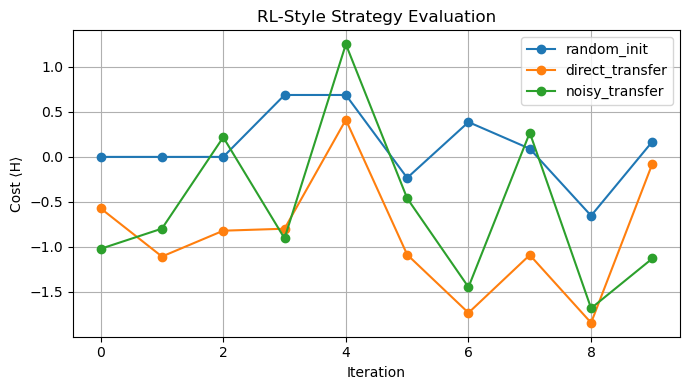

In [40]:
fig, ax = plt.subplots(figsize=(7, 4))
for name, data in costs_by_strategy.items():
    ax.plot(data["costs"], label=name, marker='o')

ax.set_xlabel("Iteration")
ax.set_ylabel("Cost ⟨H⟩")
ax.set_title("RL-Style Strategy Evaluation")
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig("results/graph_c_rl_bandit_eval.png", dpi=300)
plt.show()

In [41]:
for name, data in costs_by_strategy.items():
    print(f"{name}: final cost = {data['final_cost']:.4f}, iterations = {len(data['costs'])}")

random_init: final cost = -0.6535, iterations = 10
direct_transfer: final cost = -1.8435, iterations = 10
noisy_transfer: final cost = -1.6820, iterations = 10


In [42]:
with open("results/graph_c_rl_bandit_results.json", "w") as f:
    json.dump(costs_by_strategy, f, indent=2)